In [104]:
import argparse
import json
import gzip
import os
import urllib.request
import networkx as nx
from bz2 import BZ2File as bzopen
from urllib.request import urlopen
from networkx.readwrite import json_graph
from bs4 import BeautifulSoup
import datetime
from dateutil.relativedelta import *
import random
import shutil
from collections import defaultdict 

def update_graph(year, month, G):
    # Update graph from AS relationships data
    data_dir = 'as_relationships_data'
    fname = os.path.join(data_dir, f'{year}{month}01.as-rel.txt.bz2')
    with bzopen(fname, 'r') as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if line.startswith('#'):
                continue
            else:
                l = line.split('|')
                as1 = int(l[0])
                as2 = int(l[1])
                relationship_type = int(l[2])
                if relationship_type == -1:
                    r = 'c2p'
                elif relationship_type == 0:
                    r = 'p2p'
                else:
                    raise Exception('Invalid relationship type!')
                if (as1, as2) not in G.edges:
                    G.add_edge(as1, as2, label=r, timestamp=datetime.date(year=int(year), month=int(month), day=1))
    return G


def download_as_links_files(year, month, monitor=None):
    url = f'http://data.caida.org/datasets/topology/ark/ipv6/as-links/{year}/{month}'
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html.parser')
    links = []
    for link in soup.find_all('a'):
        l = link.get('href')
        if l.startswith('cycle-aslinks.l8') and year + month in l:
            lsplit = l.split('.')
            m = lsplit[-3]
            if (monitor is not None and monitor == m) or monitor is None:
                links.append(l)
    data_dir = 'as_links_data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    out_dir = os.path.join(data_dir, year + month)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    for l in links:
        full_link = os.path.join(url, l)
        out_file = os.path.join(out_dir, l)
        if os.path.exists(out_file):
            continue
        else:
            print(f'Downloading {full_link} to {out_file}')
            urllib.request.urlretrieve(full_link, out_file)


def download_as_relationships_file(year, month):
    l = f'{year}{month}01.as-rel.txt.bz2'
    full_link = f'http://data.caida.org/datasets/as-relationships/serial-1/{l}'
    data_dir = 'as_relationships_data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    out_file = os.path.join(data_dir, l)
    if not os.path.exists(out_file):
        print(f'Downloading {full_link} to {out_file}')
        urllib.request.urlretrieve(full_link, out_file)

        
def remove_files_(year, month):
    data_dir = 'as_links_data'
    out_dir = os.path.join(data_dir, year + month)
    print(f'Removing {out_dir}')
    shutil.rmtree(out_dir)
    data_dir = 'as_relationships_data'
    l = f'{year}{month}01.as-rel.txt.bz2'
    out_file = os.path.join(data_dir, l)
    print(f'Removing {out_file}')
    os.remove(out_file)
    

In [105]:
start_date = datetime.date(year=2018, month=12, day=1)
end_date = datetime.date(year=2019, month=1, day=1)

# monitor = 'sea-us'
# monitors = ['sea-us']
monitor = None

In [106]:
def process_as(as1, G, fname, initial=False):
    timestamp = int(fname.split('.')[3])
    if as1 not in G.nodes:
        return
#         G.add_node(as1)
    G.nodes[as1]['ipv6'] = True
    if initial:
        # Node is initially IPv6
        G.nodes[as1]['time_adopted'] = 0
        return
    else:
        # Node adopted IPv6 at this timestamp
        G.nodes[as1]['time_adopted'] = timestamp

    # Get num neighbors that have adopted IPv6
    ipv6_neighbors = 0
    for n in G.neighbors(as1):
        if G.nodes[n].get('ipv6'):
            ipv6_neighbors += 1

    G.nodes[as1]['ipv6_neighbors'] = ipv6_neighbors
    num_neighbors = len(list(G.neighbors(as1)))
    G.nodes[as1]['num_neighbors'] = num_neighbors

In [109]:
def run_analysis(start_date, end_date, m, remove_files=True):
    # Create graph from AS relationships
    G = nx.Graph()

    cur_date = start_date
    initial = True
    ipv6_nodes = set() # Set of all nodes that have adopted IPv6

    while cur_date < end_date:
        cur_month = cur_date.strftime('%m')
        cur_year = cur_date.strftime('%Y')
        print(f'{cur_month}/{cur_year}')

        download_as_links_files(cur_year, cur_month, m)
        download_as_relationships_file(cur_year, cur_month)

        G = update_graph(cur_year, cur_month, G)
        print(f'G # nodes: {len(G.nodes)}')
        print(f'G # edges: {len(G.edges)}')

        folder = os.path.join('as_links_data', cur_year + cur_month)
        fnames = sorted(os.listdir(folder))

        for fname in fnames:
            if not fname.endswith('.gz'):
                continue
            if m is not None and m not in fname:
                continue
            with gzip.open(os.path.join(folder, fname), 'r') as f:
                for i, line in enumerate(f):
                    line = line.decode('utf-8').strip()
                    if line.startswith('D') or line.startswith('I'):
                        line = line.split('\t')
                        type_ = line[0]
                        as1_list = line[1].split(',')
                        as2_list = line[2].split(',')
                        for as1 in as1_list:
                            as1 = int(as1)
                            if as1 not in ipv6_nodes: # Newly adopted IPv6
                                ipv6_nodes.add(as1)
                                process_as(as1, G, fname, initial)
                            for as2 in as2_list:
                                as2 = int(as2)
                                if as2 not in ipv6_nodes: # Newly adopted IPv6
                                    ipv6_nodes.add(as2)
                                    process_as(as2, G, fname, initial)
    #                             if (as1, as2) not in G.edges:
    #                                 print(as1, as2)
    #                                 G.add_edge(as1, as2)
            initial = False

        print(len(ipv6_nodes))
        cur_date += relativedelta(months=+1)
        
        if remove_files:
            remove_files_(cur_year, cur_month)
    return G

In [128]:
G = run_analysis(start_date, end_date, monitor, remove_files=False)

12/2018
G # nodes: 63361
G # edges: 320978
10296


In [129]:
initial_ipv6 = sum([1 for i in G.nodes if G.nodes[i].get('time_adopted') == 0])
print(initial_ipv6)
ipv6_nodes = [n for n in G.nodes if G.nodes[n].get('ipv6')]
print(len(ipv6_nodes))

8041
9880


In [140]:
for node in ipv6_nodes:
    cascade_size = calculate_cascade_size(node, 0, set())
    print(node, cascade_size)
# initial_node = random.choice(ipv6_nodes)
# print(initial_node)

3549 579
11537 363
20940 600
134090 1
265036 253
3 2
293 349
6939 1210
23248 1
33480 1
133296 1
266177 252
44217 304
55482 2
200612 341
12 4
5580 388
20 4
4323 543
24 3
2153 199
7575 370
10343 2
22388 8
32 1
3671 1
10466 207
42 491
286 388
553 352
680 322
701 15
715 1
852 356
1103 478
1267 459
1273 320
1280 209
1403 342
1764 344
1798 344
1836 359
1916 461
2018 361
2119 348
2152 211
2381 225
2497 366
3130 341
3216 208
3223 371
3257 407
3267 359
3292 354
3303 369
3333 312
3491 371
3741 413
4181 356
4608 76
4637 393
4739 394
4775 417
4777 1
4826 401
4844 309
5394 474
5413 343
5645 341
5650 210
6082 192
6461 387
6661 458
6730 380
6762 446
6830 340
6908 304
7385 351
7473 363
7660 351
7738 445
7922 346
8218 409
8220 611
8283 362
8359 367
8426 380
8447 359
8455 333
8492 421
8607 348
8758 363
8896 403
9002 400
9044 381
9304 413
9902 318
10026 482
10886 211
11096 210
11164 216
11404 357
11686 199
12307 184
12350 356
12389 368
12552 415
12637 410
12779 521
12859 460
12956 329
13030 395
13101 354

KeyboardInterrupt: 

In [141]:
def calculate_cascade_size(node, time_adopted, seen_nodes):
    cascade_size = 1
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted and neighbor not in seen_nodes:
#             print(node, time_adopted, neighbor, G.nodes[neighbor]['time_adopted'])
            seen_nodes.add(node)
            cascade_size += calculate_cascade_size(neighbor, G.nodes[neighbor]['time_adopted'], seen_nodes)
    return cascade_size

print(calculate_cascade_size(46450, 0, set()))

def build_graph(node, time_adopted, seen_nodes, c_G):
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor].get('ipv6') and G.nodes[neighbor]['time_adopted'] > time_adopted:
            c_G.add_edge(node, neighbor)
            if neighbor not in seen_nodes:
                seen_nodes.add(node)
                c_G = build_graph(neighbor, G.nodes[neighbor]['time_adopted'], seen_nodes, c_G)
    return c_G

c_G = build_graph(46450, 0, set(), nx.Graph())

56


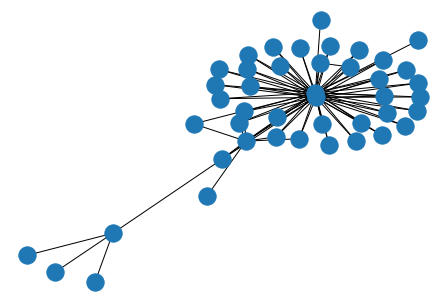

In [142]:
nx.draw(c_G)

In [112]:
print(len(list(G.neighbors(10010))))

54


In [113]:
node = random.choice(ipv6_nodes)
print(node)
print(G.nodes[node])

63414
{'ipv6': True, 'time_adopted': 0}


In [114]:
for n in G.neighbors(node):
    print(G.nodes[n])

{'ipv6': True, 'time_adopted': 0}
{}


In [37]:
avg_fraction = 0
count = 0
for n in ipv6_nodes:
    node = G.nodes[n]
    if node['time_adopted'] > 0 and node['num_neighbors'] > 0:
        avg_fraction += float(node['ipv6_neighbors']) / node['num_neighbors']
        count += 1
print(avg_fraction/float(count))

0.7708165867754263


In [85]:
(3549, 1) in G.edges

True